In [10]:
import torch
import torchvision 
from tqdm import tqdm
import matplotlib

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = torch.nn.Sequential(
            # 单通道输入（灰度图像），16通道输出，3x3卷积核
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),  #引入非线性激活函数
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 16通道输入，32通道输出，3x3卷积核
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 32通道输入，64通道输出，3x3卷积核
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            
            # 展平张量
            torch.nn.Flatten(),
            # 全连接层，输入特征为7*7*64，输出特征为128
            torch.nn.Linear(in_features=7*7*64, out_features=128),
            torch.nn.ReLU(),
            # 全连接层，输入特征为128，输出特征为10，对应0-9的10个数字
            torch.nn.Linear(in_features=128, out_features=10),
            # 输出的Softmax激活函数
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self, input):
        output = self.model(input)
        return output

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"   # 我这台是cpu
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])

# 定义超参数 && 准备数据集   
BATCH_SIZE = 256
EPOCHS = 10
trainData = torchvision.datasets.MNIST('./data/',train = True,transform = transform,download = True)
testData = torchvision.datasets.MNIST('./data/',train = False,transform = transform)


trainDataLoader = torch.utils.data.DataLoader(dataset = trainData,batch_size = BATCH_SIZE,shuffle = True)
testDataLoader = torch.utils.data.DataLoader(dataset = testData,batch_size = BATCH_SIZE)
net = Net()

lossF = torch.nn.CrossEntropyLoss()                 # 交叉熵损失函数
optimizer = torch.optim.Adam(net.parameters())      # Adam优化器

In [13]:
history = {'Test Loss':[],'Test Accuracy':[]}  # 记录测试集损失和准确率
for epoch in range(1,EPOCHS + 1):
    # 训练集训练
    processBar = tqdm(trainDataLoader,unit = 'step')  # 进度条
    net.train(True)  # 训练模式
    for step,(trainImgs,labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device) 
        labels = labels.to(device)  

        net.zero_grad()  # 梯度清零
        outputs = net(trainImgs)  # 前向传播
        loss = lossF(outputs,labels)  # 计算损失
        predictions = torch.argmax(outputs, dim = 1)  # 获取预测结果
        accuracy = torch.sum(predictions == labels)/labels.shape[0]  # 计算准确率
        loss.backward()  # 反向传播

        optimizer.step()  # 更新参数
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item()))
        
        # 测试集验证
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            net.train(False)  # 测试模式
            with torch.no_grad():  # 不计算梯度 优化性能
                for testImgs,labels in testDataLoader:
                    testImgs = testImgs.to(device) 
                    labels = labels.to(device) 
                    outputs = net(testImgs)  # 前向传播
                    loss = lossF(outputs,labels)  # 计算损失
                    predictions = torch.argmax(outputs,dim = 1)  # 获取预测结果
                    
                    totalLoss += loss  # 累加损失
                    correct += torch.sum(predictions == labels)  # 累加正确预测数
                    
                testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))  # 计算测试集准确率
                testLoss = totalLoss/len(testDataLoader)  # 计算测试集平均损失
                history['Test Loss'].append(testLoss.item())  # 记录测试集损失
                history['Test Accuracy'].append(testAccuracy.item())  # 记录测试集准确率
            
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()  # 关闭进度条


[1/10] Loss: 1.4619, Acc: 0.9167, Test Loss: 1.5065, Test Acc: 0.9344: 100%|██████████| 235/235 [00:18<00:00, 12.41step/s]
[2/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4867, Test Acc: 0.9522: 100%|██████████| 235/235 [00:19<00:00, 12.03step/s]
[3/10] Loss: 1.4612, Acc: 0.9479, Test Loss: 1.4794, Test Acc: 0.9596: 100%|██████████| 235/235 [00:19<00:00, 12.23step/s]
[4/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4771, Test Acc: 0.9611: 100%|██████████| 235/235 [00:19<00:00, 12.35step/s]
[5/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4748, Test Acc: 0.9631: 100%|██████████| 235/235 [00:19<00:00, 12.25step/s]
[6/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4728, Test Acc: 0.9652: 100%|██████████| 235/235 [00:19<00:00, 12.29step/s]
[7/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4720, Test Acc: 0.9656: 100%|██████████| 235/235 [00:18<00:00, 12.53step/s]
[8/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4716, Test Acc: 0.9662: 100%|██████████| 235/235 [00:18<00:00, 12.56step/s]
[9/10] Loss: 1.4

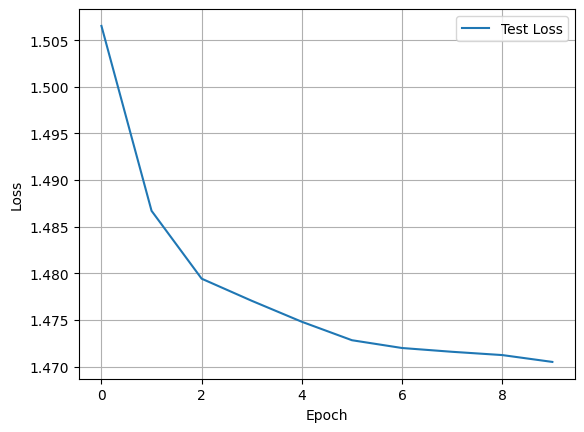

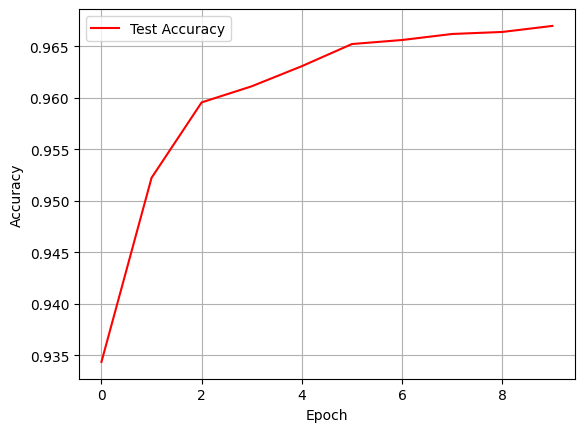

In [15]:
import os
import matplotlib.pyplot as plt

plt.plot(history['Test Loss'],label = 'Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 确保路径存在
os.makedirs(os.path.dirname('./model.pth'), exist_ok=True)

torch.save(net, './model.pth')  # 保存模型